## Pytorch example
Taken from https://github.com/rguthrie3/DeepLearningForNLPInPytorch/blob/master/Deep%20Learning%20for%20Natural%20Language%20Processing%20with%20Pytorch.ipynb

In [1]:
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np

from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("poster")
sns.set_style("ticks")


## Creating variables

In [2]:
a = np.random.rand(10)
a

array([ 0.70489916,  0.32993783,  0.87887926,  0.27641057,  0.91079612,
        0.15268316,  0.74322504,  0.90257215,  0.2456033 ,  0.39390593])

In [3]:
a_tch = torch.Tensor(a)
a_tch


 0.7049
 0.3299
 0.8789
 0.2764
 0.9108
 0.1527
 0.7432
 0.9026
 0.2456
 0.3939
[torch.FloatTensor of size 10]

In [4]:
a_tch[0]

0.7048991322517395

In [5]:
a_tch = torch.rand((2,3,4))
a_tch


(0 ,.,.) = 
  0.4170  0.9972  0.7203  0.9326
  0.0001  0.1281  0.3023  0.9990
  0.1468  0.2361  0.0923  0.3966

(1 ,.,.) = 
  0.1863  0.3879  0.3456  0.6697
  0.3968  0.9355  0.5388  0.8463
  0.4192  0.3133  0.6852  0.5245
[torch.FloatTensor of size 2x3x4]

In [6]:
x = torch.Tensor([[0, 1.], [2, 3]])
y = torch.Tensor([[1, 4.], [5, 3]])
x+y


 1  5
 7  6
[torch.FloatTensor of size 2x2]

In [7]:
torch.cat([x,y], 1)


 0  1  1  4
 2  3  5  3
[torch.FloatTensor of size 2x4]

In [8]:
x.view((1,-1))


 0  1  2  3
[torch.FloatTensor of size 1x4]

## Autograd

In [9]:
x = Variable(torch.Tensor([1,2]), requires_grad=True)
print(x.data)


 1
 2
[torch.FloatTensor of size 2]



In [10]:
x

Variable containing:
 1
 2
[torch.FloatTensor of size 2]

In [11]:
y = Variable(torch.Tensor([3,5]), requires_grad=True)
z = x+y
z

Variable containing:
 4
 7
[torch.FloatTensor of size 2]

In [12]:
z.creator

In [13]:
s = z.sum()
s.creator

In [14]:
s.backward()
print(x.grad)

Variable containing:
 1
 1
[torch.FloatTensor of size 2]



In [15]:
## Tensors are data objects
x = torch.rand((2,2))
y = torch.rand((2,2))
z = x+y

## Variables are variable objects also contain the grad details and computational graph details
var_x = Variable(x)
var_y = Variable(y)
var_z = var_x + var_y
print(var_z.creator)

## I am breaking the chain of the variable by creating a new variable with same data. 
## Gradients will not propogate
var_z_data = var_z.data
new_var_z = Variable(var_z_data)
print(new_var_z.creator)


None


In [16]:
x.size()

torch.Size([2, 2])

In [17]:
var_x.data.size()

torch.Size([2, 2])

In [18]:
torch.randn(1)


-0.9596
[torch.FloatTensor of size 1]

In [19]:
torch.randn([1,2]).expand_as(torch.randn((2,2))) + torch.randn((2,2))


 2.1934 -0.4928
-0.9578  0.7760
[torch.FloatTensor of size 2x2]

In [20]:
var_x.transpose(1,0)

Variable containing:
 0.2045  0.8781
 0.4435  0.2296
[torch.FloatTensor of size 2x2]

## Building blocks

In [21]:
l1 = nn.Linear(x.size(1), 4)
h1 = l1(var_x)
F.relu(h1)

Variable containing:
 0.0000  0.5331  0.0000  0.0000
 0.0000  0.7109  0.0000  0.2759
[torch.FloatTensor of size 2x4]

In [22]:
F.softmax(h1)

Variable containing:
 0.1062  0.4435  0.1901  0.2601
 0.0826  0.4353  0.2002  0.2818
[torch.FloatTensor of size 2x4]

In [23]:
F.softmax(h1).sum(1)

Variable containing:
 1
 1
[torch.FloatTensor of size 2x1]

## Language prediction

In [24]:
data = [ ("me gusta comer en la cafeteria".split(), "SPANISH"),
         ("Give it to me".split(), "ENGLISH"),
         ("No creo que sea una buena idea".split(), "SPANISH"),
         ("No it is not a good idea to get lost at sea".split(), "ENGLISH") ]

test_data = [ ("Yo creo que si".split(), "SPANISH"),
              ("it is lost on me".split(), "ENGLISH")]

In [25]:
class Vocab(object):
    def __init__(self, name="vocab",
                 offset_items=tuple([]),
                 UNK=None):
        self.name = name
        self.item2idx = {}
        self.idx2item = []
        self.size = 0
        self.UNK = UNK
        
        self.batch_add(offset_items)
        if UNK is not None:
            self.add(UNK)
            self.UNK_ID = self.item2idx[self.UNK]
        self.offset = self.size
        
    def add(self, item):
        if item not in self.item2idx:
            self.item2idx[item] = self.size
            self.size += 1
            self.idx2item.append(item)
            
    def batch_add(self, items):
        for item in items:
            self.add(item)
            
    def getidx(self, item):
        if item not in self.item2idx:
            if self.UNK is None:
                raise RuntimeError("UNK is not defined. %s not in vocab." % item)
            return self.UNK_ID
        return self.item2idx[item]
            
    def __repr__(self):
        return "Vocab(name={}, size={:d}, UNK={}, offset={:d})".format(
            self.name, self.size,
            self.UNK, self.offset
        )

In [26]:
word_vocab = Vocab("words", UNK="UNK")
label_vocab = Vocab("labels")

for sent, label in data:
    label_vocab.add(label)
    for word in sent:
        word_vocab.add(word)

print(word_vocab, word_vocab.idx2item, word_vocab.item2idx)
print(label_vocab, label_vocab.idx2item, label_vocab.item2idx)

Vocab(name=words, size=24, UNK=UNK, offset=1) ['UNK', 'me', 'gusta', 'comer', 'en', 'la', 'cafeteria', 'Give', 'it', 'to', 'No', 'creo', 'que', 'sea', 'una', 'buena', 'idea', 'is', 'not', 'a', 'good', 'get', 'lost', 'at'] {'creo': 11, 'a': 19, 'No': 10, 'UNK': 0, 'que': 12, 'gusta': 2, 'en': 4, 'una': 14, 'is': 17, 'it': 8, 'get': 21, 'not': 18, 'cafeteria': 6, 'lost': 22, 'Give': 7, 'la': 5, 'to': 9, 'idea': 16, 'good': 20, 'buena': 15, 'comer': 3, 'sea': 13, 'me': 1, 'at': 23}
Vocab(name=labels, size=2, UNK=None, offset=0) ['SPANISH', 'ENGLISH'] {'ENGLISH': 1, 'SPANISH': 0}


In [27]:
class BoWModule(nn.Module):
    def __init__(self, input_size, output_size):
        super(BoWModule, self).__init__()
        self.W = nn.Linear(input_size, output_size)
        
    def forward(self, X):
        return F.log_softmax(self.W(X))

In [28]:
class Seq2Vec(object):
    def __init__(self, vocab):
        self.vocab = vocab
        
    def encode(self, seq):
        vec = []
        for item in seq:
            vec.append(self.vocab.getidx(item))
        return vec
    
    def batch_encode(self, seq_batch):
        vecs = [self.encode(seq) for seq in seq_batch]
        return vecs
        
        
class Seq2OneHot(object):
    def __init__(self, size):
        self.size = size
    
    def encode(self, x, as_variable=False):
        one_hot = torch.zeros(self.size)
        for i in x:
            one_hot[i] += 1
        one_hot = one_hot.view(1, -1)
        if as_variable:
            return Variable(one_hot)
        return one_hot
        

In [29]:
sent_encoder = Seq2Vec(word_vocab)

def data2vec(data):
    X, y = [], []
    for sent, label in data:
        y.append([label_vocab.getidx(label)])
        X.append(sent_encoder.encode(sent))
    return X, y

X_train, y_train = data2vec(data)
X_test, y_test = data2vec(test_data) 
print(X_train, y_train, X_test, y_test)


sent_onehot_encoder = Seq2OneHot(word_vocab.size)
print(sent_onehot_encoder.encode(X_train[0]))

[[1, 2, 3, 4, 5, 6], [7, 8, 9, 1], [10, 11, 12, 13, 14, 15, 16], [10, 8, 17, 18, 19, 20, 16, 9, 21, 22, 23, 13]] [[0], [1], [0], [1]] [[0, 11, 12, 0], [8, 17, 22, 0, 1]] [[0], [1]]


Columns 0 to 12 
    0     1     1     1     1     1     1     0     0     0     0     0     0

Columns 13 to 23 
    0     0     0     0     0     0     0     0     0     0     0
[torch.FloatTensor of size 1x24]



In [30]:
model = BoWModule(word_vocab.size, label_vocab.size)
log_probs = model.forward(sent_onehot_encoder.encode(X_train[0], as_variable=True))
print("Log probs: ", log_probs)

Log probs:  Variable containing:
-0.9682 -0.4777
[torch.FloatTensor of size 1x2]



In [31]:
def print_log_probs(log_probs, label_vocab, label_true=None):
    for i, label_probs in enumerate(log_probs.data.tolist()):
        prob_string = ", ".join([
            "{}: {:.3f}".format(label_vocab.idx2item[j], val)
            for j, val in enumerate(label_probs)
        ])
        true_string = "?"
        if label_true is not None:
            true_string = label_vocab.idx2item[label_true[i]]
            
        print(prob_string, "True label: ", true_string)

In [32]:
print_log_probs(log_probs, label_vocab)

SPANISH: -0.968, ENGLISH: -0.478 True label:  ?


In [33]:
for seq, label in zip(X_test, y_test):
    log_probs = model.forward(sent_onehot_encoder.encode(seq, as_variable=True))
    print_log_probs(log_probs, label_vocab, label_true=label)

SPANISH: -1.428, ENGLISH: -0.274 True label:  SPANISH
SPANISH: -0.807, ENGLISH: -0.591 True label:  ENGLISH


In [34]:
next(model.parameters())[:, word_vocab.getidx("creo")]

Variable containing:
-0.1235
-0.0126
[torch.FloatTensor of size 2]

## Training time

In [35]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

def get_loss(loss_function, seq, label, verbose=False):
    ## Clear gradients before every update else memory runs out
    model.zero_grad()
    ## Do forward pass
    log_probs = model.forward(sent_onehot_encoder.encode(seq, as_variable=True))
    if verbose:
        print(log_probs)
    ## Get labels
    target  = Variable(torch.LongTensor(label))
    if verbose:
        print(target)
    ## Get loss
    loss = loss_function(log_probs, target)
    if verbose:
        print(loss)
    return loss

In [36]:
loss = get_loss(loss_function, X_train[0], y_train[0], verbose=True)

Variable containing:
-0.9682 -0.4777
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.9682
[torch.FloatTensor of size 1]



In [37]:
loss.data[0]

0.9681910276412964

In [38]:
losses = []
for epoch in tqdm(range(100)):
    for seq, label in zip(X_train, y_train):
        loss = get_loss(loss_function, seq, label)
        losses.append(loss.data[0])
        ## Get gradients of model params wrt. loss
        loss.backward()
        ## Optimize the loss by one step
        optimizer.step()

100%|██████████| 100/100 [00:00<00:00, 321.49it/s]


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


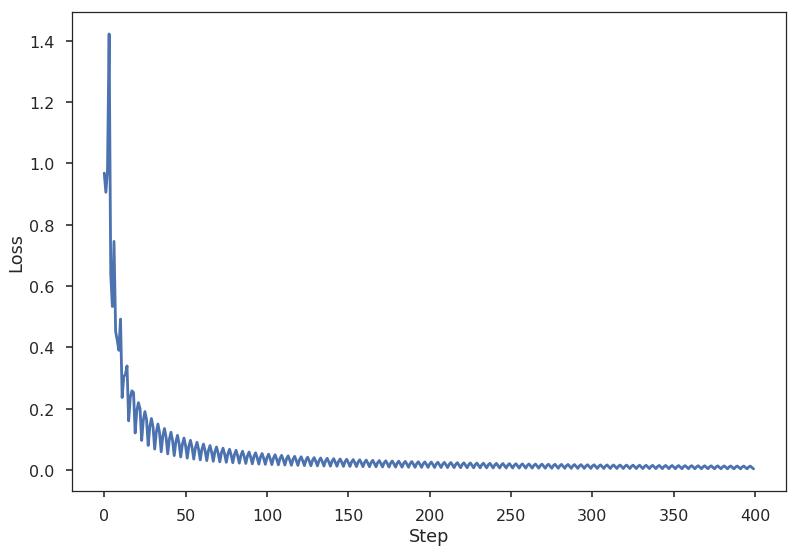

In [39]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")

In [40]:
for seq, label in zip(X_test, y_test):
    log_probs = model.forward(sent_onehot_encoder.encode(seq, as_variable=True))
    print_log_probs(log_probs, label_vocab, label_true=label)

SPANISH: -0.307, ENGLISH: -1.331 True label:  SPANISH
SPANISH: -3.080, ENGLISH: -0.047 True label:  ENGLISH


## Embeddings

In [41]:
word_embeddings = nn.Embedding(word_vocab.size, 5)
word_embeddings

Embedding(24, 5)

In [42]:
word_embeddings(Variable(torch.LongTensor([X_test[0]])))

Variable containing:
(0 ,.,.) = 
 -0.3569 -0.0822  0.8388 -1.3233  0.0701
  1.1375 -1.0246 -1.0300 -1.0129  0.0055
 -0.9347 -0.9882  1.3801 -0.1173  0.9317
 -0.3569 -0.0822  0.8388 -1.3233  0.0701
[torch.FloatTensor of size 1x4x5]

In [43]:
X_test[0]

[0, 11, 12, 0]

In [44]:
word_embeddings(Variable(torch.LongTensor([X_test[0]]))).mean(1).view(-1, 5)

Variable containing:
-0.1278 -0.5443  0.5069 -0.9442  0.2694
[torch.FloatTensor of size 1x5]

In [45]:
word_embeddings.embedding_dim

5

In [46]:
class BoEmbeddingsModule(nn.Module):
    def __init__(self, vocab_size, embedding_size, output_size):
        super(BoEmbeddingsModule, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.W = nn.Linear(embedding_size, output_size)
        
    def forward(self, X):
        hidden_layer = self.word_embeddings(X).mean(1).view(-1,self.word_embeddings.embedding_dim)
        return F.log_softmax(self.W(hidden_layer))

In [47]:
model = BoEmbeddingsModule(word_vocab.size, 5, label_vocab.size)
log_probs = model.forward(Variable(torch.LongTensor([X_test[0]])))
print("Log probs: ", log_probs)

Log probs:  Variable containing:
-0.8506 -0.5571
[torch.FloatTensor of size 1x2]



In [48]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

def get_loss_embedding(loss_function, seq, label, verbose=False):
    ## Clear gradients before every update else memory runs out
    model.zero_grad()
    ## Do forward pass
    log_probs = model.forward(Variable(torch.LongTensor([seq])))
    if verbose:
        print(log_probs)
    ## Get labels
    target  = Variable(torch.LongTensor(label))
    if verbose:
        print(target)
    ## Get loss
    loss = loss_function(log_probs, target)
    if verbose:
        print(loss)
    return loss

In [49]:
loss = get_loss_embedding(loss_function, X_train[0], y_train[0], verbose=True)

Variable containing:
-0.9180 -0.5097
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.9180
[torch.FloatTensor of size 1]



100%|██████████| 100/100 [00:00<00:00, 446.46it/s]


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


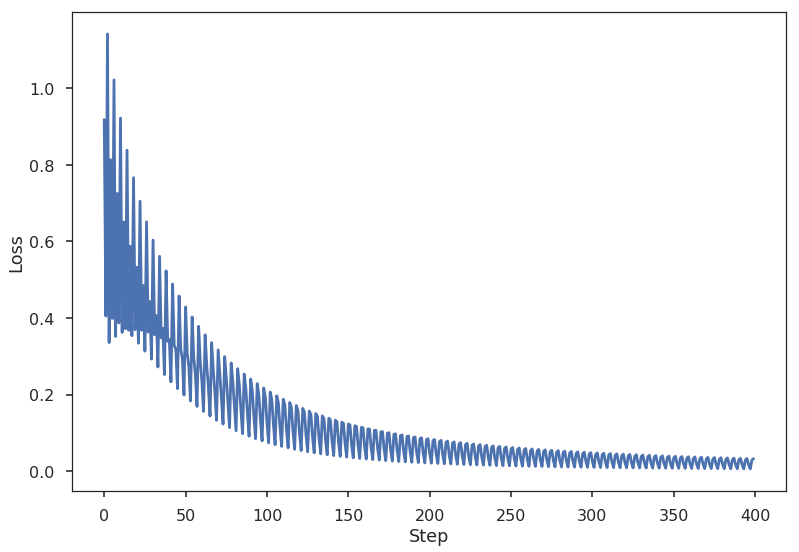

In [50]:
losses = []
for epoch in tqdm(range(100)):
    for seq, label in zip(X_train, y_train):
        loss = get_loss_embedding(loss_function, seq, label)
        losses.append(loss.data[0])
        ## Get gradients of model params wrt. loss
        loss.backward()
        ## Optimize the loss by one step
        optimizer.step()
        
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")        

## LSTM

In [51]:
word_embeddings(Variable(torch.LongTensor([X_test[0]])))

Variable containing:
(0 ,.,.) = 
 -0.3569 -0.0822  0.8388 -1.3233  0.0701
  1.1375 -1.0246 -1.0300 -1.0129  0.0055
 -0.9347 -0.9882  1.3801 -0.1173  0.9317
 -0.3569 -0.0822  0.8388 -1.3233  0.0701
[torch.FloatTensor of size 1x4x5]

In [52]:
word_embeddings(Variable(torch.LongTensor([X_test[0]]))).permute(1, 0, 2)

Variable containing:
(0 ,.,.) = 
 -0.3569 -0.0822  0.8388 -1.3233  0.0701

(1 ,.,.) = 
  1.1375 -1.0246 -1.0300 -1.0129  0.0055

(2 ,.,.) = 
 -0.9347 -0.9882  1.3801 -0.1173  0.9317

(3 ,.,.) = 
 -0.3569 -0.0822  0.8388 -1.3233  0.0701
[torch.FloatTensor of size 4x1x5]

In [53]:
lstm = nn.LSTM(5,2)
input_units = word_embeddings(Variable(torch.LongTensor([X_test[0]]))).permute(1, 0, 2)
hidden_units = (Variable(torch.randn(1,1,2)), Variable(torch.randn((1,1,2))))

In [54]:
lstm

LSTM(5, 2)

In [55]:
input_units

Variable containing:
(0 ,.,.) = 
 -0.3569 -0.0822  0.8388 -1.3233  0.0701

(1 ,.,.) = 
  1.1375 -1.0246 -1.0300 -1.0129  0.0055

(2 ,.,.) = 
 -0.9347 -0.9882  1.3801 -0.1173  0.9317

(3 ,.,.) = 
 -0.3569 -0.0822  0.8388 -1.3233  0.0701
[torch.FloatTensor of size 4x1x5]

In [56]:
hidden_units

(Variable containing:
 (0 ,.,.) = 
  -0.2699 -0.1599
 [torch.FloatTensor of size 1x1x2], Variable containing:
 (0 ,.,.) = 
  -0.0057  1.0992
 [torch.FloatTensor of size 1x1x2])

In [57]:
input_units[:1, :, :]

Variable containing:
(0 ,.,.) = 
 -0.3569 -0.0822  0.8388 -1.3233  0.0701
[torch.FloatTensor of size 1x1x5]

In [58]:
Variable(torch.randn((1,5))).view(1,1,-1)

Variable containing:
(0 ,.,.) = 
  0.1496  2.4154 -0.8190  0.4201 -0.7981
[torch.FloatTensor of size 1x1x5]

In [59]:
lstm(input_units[:1, :, :], hidden_units)

(Variable containing:
 (0 ,.,.) = 
  -0.0864  0.1397
 [torch.FloatTensor of size 1x1x2], (Variable containing:
  (0 ,.,.) = 
   -0.0864  0.1397
  [torch.FloatTensor of size 1x1x2], Variable containing:
  (0 ,.,.) = 
   -0.2551  0.2165
  [torch.FloatTensor of size 1x1x2]))

In [60]:
lstm(input_units, hidden_units)

(Variable containing:
 (0 ,.,.) = 
  -0.0864  0.1397
 
 (1 ,.,.) = 
   0.1784 -0.0851
 
 (2 ,.,.) = 
  -0.1222 -0.2234
 
 (3 ,.,.) = 
  -0.1724 -0.3081
 [torch.FloatTensor of size 4x1x2], (Variable containing:
  (0 ,.,.) = 
   -0.1724 -0.3081
  [torch.FloatTensor of size 1x1x2], Variable containing:
  (0 ,.,.) = 
   -0.5355 -0.4977
  [torch.FloatTensor of size 1x1x2]))

In [61]:
out, hidden = lstm(input_units, hidden_units)
out, hidden

(Variable containing:
 (0 ,.,.) = 
  -0.0864  0.1397
 
 (1 ,.,.) = 
   0.1784 -0.0851
 
 (2 ,.,.) = 
  -0.1222 -0.2234
 
 (3 ,.,.) = 
  -0.1724 -0.3081
 [torch.FloatTensor of size 4x1x2], (Variable containing:
  (0 ,.,.) = 
   -0.1724 -0.3081
  [torch.FloatTensor of size 1x1x2], Variable containing:
  (0 ,.,.) = 
   -0.5355 -0.4977
  [torch.FloatTensor of size 1x1x2]))

In [62]:
out[-1, :, :]

Variable containing:
-0.1724 -0.3081
[torch.FloatTensor of size 1x2]

In [63]:
F.log_softmax(out[-1, :, :])

Variable containing:
-0.6276 -0.7633
[torch.FloatTensor of size 1x2]

In [64]:
class LSTMPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size):
        super(LSTMPredictor, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        seq_embed = self.word_embeddings(X).permute(1, 0, 2)
        out, hidden = self.lstm(seq_embed)
        output = self.output(out[-1, :, :])
        return F.log_softmax(output)

In [65]:
model = LSTMPredictor(word_vocab.size, 5, 3, label_vocab.size)
log_probs = model.forward(Variable(torch.LongTensor([X_test[0]])))
print("Log probs: ", log_probs)

Log probs:  Variable containing:
-0.7077 -0.6788
[torch.FloatTensor of size 1x2]



In [66]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

def get_loss_embedding_lstm(model, loss_function, seq, label, verbose=False):
    ## Clear gradients before every update else memory runs out
    model.zero_grad()
    ## Do forward pass
    log_probs = model.forward(Variable(torch.LongTensor([seq])))
    if verbose:
        print(log_probs)
    ## Get labels
    target  = Variable(torch.LongTensor(label))
    if verbose:
        print(target)
    ## Get loss
    loss = loss_function(log_probs, target)
    if verbose:
        print(loss)
    return loss

In [67]:
loss = get_loss_embedding_lstm(model, loss_function, X_train[0], y_train[0], verbose=True)

Variable containing:
-0.4848 -0.9566
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.4848
[torch.FloatTensor of size 1]



100%|██████████| 100/100 [00:01<00:00, 69.87it/s]


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


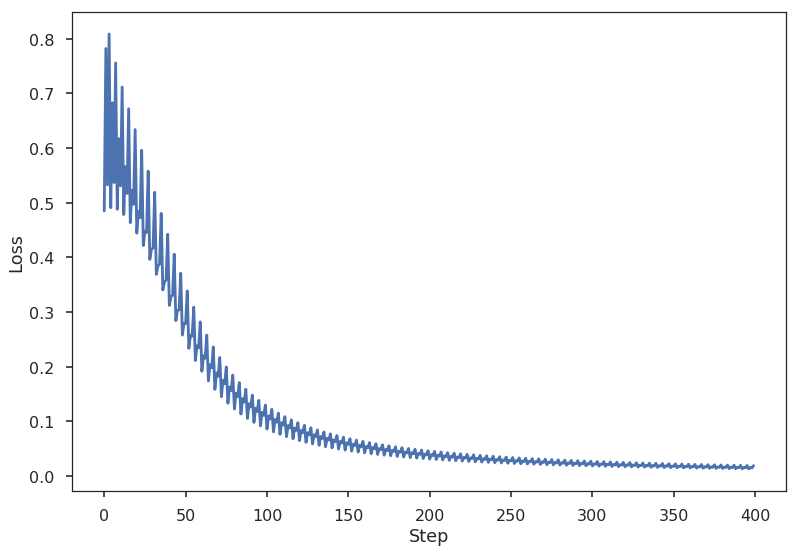

In [68]:
losses = []
for epoch in tqdm(range(100)):
    for seq, label in zip(X_train, y_train):
        loss = get_loss_embedding_lstm(model, loss_function, seq, label)
        losses.append(loss.data[0])
        ## Get gradients of model params wrt. loss
        loss.backward()
        ## Optimize the loss by one step
        optimizer.step()
        
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")

## POS Tagger

In [69]:
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

In [70]:
word_vocab = Vocab("words", UNK="UNK")
pos_vocab = Vocab("pos_tags")

for sent, pos_tags in training_data:
    for word, pos in zip(sent, pos_tags):
        word_vocab.add(word)
        pos_vocab.add(pos)

print(word_vocab, word_vocab.idx2item, word_vocab.item2idx)
print(pos_vocab, pos_vocab.idx2item, pos_vocab.item2idx)

Vocab(name=words, size=10, UNK=UNK, offset=1) ['UNK', 'The', 'dog', 'ate', 'the', 'apple', 'Everybody', 'read', 'that', 'book'] {'apple': 5, 'that': 8, 'ate': 3, 'The': 1, 'read': 7, 'dog': 2, 'Everybody': 6, 'book': 9, 'UNK': 0, 'the': 4}
Vocab(name=pos_tags, size=3, UNK=None, offset=0) ['DET', 'NN', 'V'] {'DET': 0, 'V': 2, 'NN': 1}


In [71]:
sent_encoder = Seq2Vec(word_vocab)
pos_encoder = Seq2Vec(pos_vocab)

def dataseq2vec(data):
    X, Y = [], []
    for sent, tags in data:
        X.append(sent_encoder.encode(sent))
        Y.append(pos_encoder.encode(tags))
    return X, Y

X_train, Y_train = dataseq2vec(training_data)
print(X_train, Y_train)

[[1, 2, 3, 4, 5], [6, 7, 8, 9]] [[0, 1, 2, 0, 1], [1, 2, 0, 1]]


In [72]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size):
        super(LSTMTagger, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        seq_embed = self.word_embeddings(X).permute(1, 0, 2)
        out, hidden = self.lstm(seq_embed)
        # Reshape the output to be a tensor of shape seq_len*label_size
        output = self.output(out.view(X.data.size(1), -1))
        return F.log_softmax(output)

In [73]:
word_vocab

Vocab(name=words, size=10, UNK=UNK, offset=1)

In [74]:
model = LSTMTagger(word_vocab.size, 5, 3, pos_vocab.size)
log_probs = model.forward(Variable(torch.LongTensor([X_train[0]])))
print("Log probs: ", log_probs)

Log probs:  Variable containing:
-0.8773 -0.9818 -1.5632
-0.8260 -1.0724 -1.5140
-0.8364 -1.0424 -1.5412
-0.8753 -1.0138 -1.5123
-0.8187 -1.1284 -1.4462
[torch.FloatTensor of size 5x3]



In [75]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

def get_loss_embedding_lstm_tagger(model, loss_function, seq, label, verbose=False):
    ## Clear gradients before every update else memory runs out
    model.zero_grad()
    ## Do forward pass
    log_probs = model.forward(Variable(torch.LongTensor([seq])))
    if verbose:
        print(log_probs)
    ## Get labels
    target  = Variable(torch.LongTensor(label))
    if verbose:
        print(target)
    ## Get loss
    loss = loss_function(log_probs, target)
    if verbose:
        print(loss)
    return loss

In [76]:
loss = get_loss_embedding_lstm_tagger(model, loss_function, X_train[0], Y_train[0], verbose=True)

Variable containing:
-0.8773 -0.9818 -1.5632
-0.8260 -1.0724 -1.5140
-0.8364 -1.0424 -1.5412
-0.8753 -1.0138 -1.5123
-0.8187 -1.1284 -1.4462
[torch.FloatTensor of size 5x3]

Variable containing:
 0
 1
 2
 0
 1
[torch.LongTensor of size 5]

Variable containing:
 1.0989
[torch.FloatTensor of size 1]



100%|██████████| 100/100 [00:00<00:00, 188.32it/s]


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


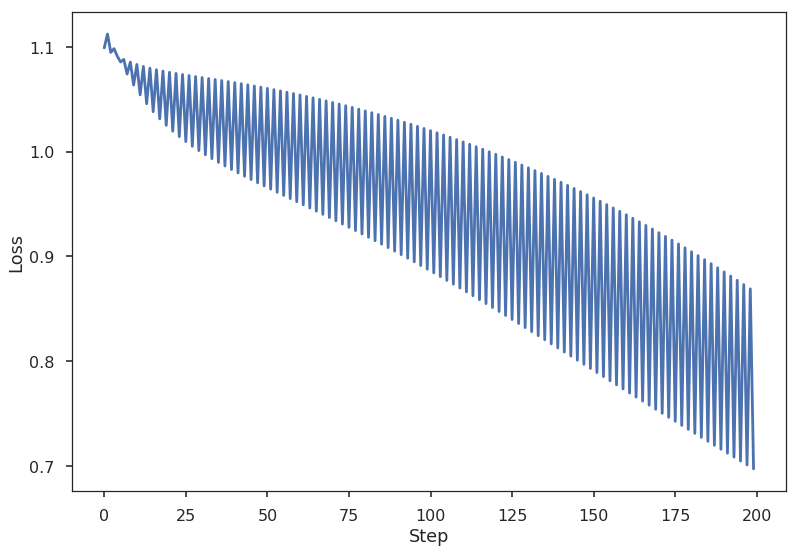

In [77]:
losses = []
for epoch in tqdm(range(100)):
    for seq, label in zip(X_train, Y_train):
        loss = get_loss_embedding_lstm_tagger(model, loss_function, seq, label)
        losses.append(loss.data[0])
        ## Get gradients of model params wrt. loss
        loss.backward()
        ## Optimize the loss by one step
        optimizer.step()
        
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")

## Char embeddings + Word embeddings

In [78]:
word_vocab = Vocab("words", UNK="UNK")
char_vocab = Vocab("chars", UNK="<U>")
pos_vocab = Vocab("pos_tags")

for sent, pos_tags in training_data:
    for word, pos in zip(sent, pos_tags):
        word_vocab.add(word)
        pos_vocab.add(pos)
        char_vocab.batch_add(word)

print(word_vocab, word_vocab.idx2item, word_vocab.item2idx)
print(char_vocab, char_vocab.idx2item, char_vocab.item2idx)
print(pos_vocab, pos_vocab.idx2item, pos_vocab.item2idx)

Vocab(name=words, size=10, UNK=UNK, offset=1) ['UNK', 'The', 'dog', 'ate', 'the', 'apple', 'Everybody', 'read', 'that', 'book'] {'apple': 5, 'that': 8, 'ate': 3, 'The': 1, 'read': 7, 'dog': 2, 'Everybody': 6, 'book': 9, 'UNK': 0, 'the': 4}
Vocab(name=chars, size=17, UNK=<U>, offset=1) ['<U>', 'T', 'h', 'e', 'd', 'o', 'g', 'a', 't', 'p', 'l', 'E', 'v', 'r', 'y', 'b', 'k'] {'y': 14, 'd': 4, 'h': 2, 'a': 7, 'b': 15, 'T': 1, 'l': 10, 'o': 5, 'k': 16, 'g': 6, 'E': 11, 'v': 12, '<U>': 0, 't': 8, 'r': 13, 'e': 3, 'p': 9}
Vocab(name=pos_tags, size=3, UNK=None, offset=0) ['DET', 'NN', 'V'] {'DET': 0, 'V': 2, 'NN': 1}


In [79]:
sent_encoder = Seq2Vec(word_vocab)
char_encoder = Seq2Vec(char_vocab)
pos_encoder = Seq2Vec(pos_vocab)

def dataseqchar2vec(data):
    X, X_char, Y = [], [], []
    for sent, tags in data:
        X.append(sent_encoder.encode(sent))
        X_char.append(char_encoder.batch_encode(sent))
        Y.append(pos_encoder.encode(tags))
    return X, X_char, Y

X_train, X_char_train, Y_train = dataseqchar2vec(training_data)
print(X_train, X_char_train, Y_train)

[[1, 2, 3, 4, 5], [6, 7, 8, 9]] [[[1, 2, 3], [4, 5, 6], [7, 8, 3], [8, 2, 3], [7, 9, 9, 10, 3]], [[11, 12, 3, 13, 14, 15, 5, 4, 14], [13, 3, 7, 4], [8, 2, 7, 8], [15, 5, 5, 16]]] [[0, 1, 2, 0, 1], [1, 2, 0, 1]]


In [80]:
class CharEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_size,
                 out_channels, kernel_sizes, dropout=0.5):
        super(CharEmbedding, self).__init__()
        self.char_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.convs1 = [nn.Conv2d(1, out_channels, (K, embedding_size)) 
                       for K in kernel_sizes]
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X):
        x = self.char_embeddings(X)
        # Ref: https://github.com/Shawn1993/cnn-text-classification-pytorch/blob/master/model.py
        x = x.unsqueeze(1) # (N,Ci,W,D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] #[(N,Co,W), ...]*len(Ks)
        x = [F.max_pool1d(self.dropout(i), i.size(2)).squeeze(2) for i in x] #[(N,Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        
        return self.dropout(x)

In [81]:
X_char_train[0][2]

[7, 8, 3]

In [82]:
char_embedding = CharEmbedding(char_vocab.size, 5, 4, [2, 3])
char_embedding(Variable(torch.LongTensor([X_char_train[0][2]])))

Variable containing:
 2.7443  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.6250
[torch.FloatTensor of size 1x8]

In [83]:
torch.cat([
    char_embedding(Variable(torch.LongTensor([x]))).unsqueeze(0)
    for x in X_char_train[0]
          ], 1)

Variable containing:
(0 ,.,.) = 
  0.0000  0.0000  0.0000  0.0000  2.4643  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  2.9619  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  5.5457  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.5848
  2.9610  0.0000  1.0892  4.7171  2.7581  0.0000  5.3865  4.0242
[torch.FloatTensor of size 1x5x8]

In [84]:
class WordCharEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_size,
                 char_embedding_model, dropout=0.5):
        super(WordCharEmbedding, self).__init__()
        self.char_embeddings = char_embedding_model
        self.word_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X, X_char=None):
        # Ref: https://github.com/Shawn1993/cnn-text-classification-pytorch/blob/master/model.py
        word_vecs = self.word_embeddings(X)
        if X_char is not None:
            char_vecs = torch.cat([
                self.char_embeddings(x).unsqueeze(0)
                for x in X_char
            ], 1)
            word_vecs = char_vecs + word_vecs
        return self.dropout(word_vecs)

In [85]:
Variable(torch.Tensor(X_train[0]))

Variable containing:
 1
 2
 3
 4
 5
[torch.FloatTensor of size 5]

In [86]:
def charseq2varlist(X_chars):
    return [Variable(torch.LongTensor([x])) for x in X_chars]

In [87]:
word_char_embedding = WordCharEmbedding(word_vocab.size, 8, char_embedding, dropout=0)
word_char_embedding(Variable(torch.LongTensor([X_train[0]])), charseq2varlist(X_char_train[0]))

Variable containing:
(0 ,.,.) = 
  5.8556  1.2501  1.5115  0.3571  1.3092  1.2664 -0.7241 -0.2907
 -0.1620 -0.3580 -0.1261 -0.3806  1.0674  0.5853 -0.9918 -1.2741
  0.5484  0.4085 -0.2132 -0.0653 -0.2304 -0.3716  0.0516  0.6814
  0.6918  1.7022 -0.2582  0.5488  0.8628  0.6860  2.2349 -1.1200
  1.6643 -0.8964  6.1735  3.5807  0.7116  1.0542  3.0053  0.1171
[torch.FloatTensor of size 1x5x8]

In [88]:
class LSTMTaggerWordChar(nn.Module):
    def __init__(self, word_char_embedding, embedding_size, hidden_size, output_size):
        super(LSTMTaggerWordChar, self).__init__()
        self.word_embeddings = word_char_embedding
        self.lstm = nn.LSTM(embedding_size, hidden_size//2, bidirectional=True)
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, X, X_char):
        seq_embed = self.word_embeddings(X, X_char).permute(1, 0, 2)
        out, hidden = self.lstm(seq_embed)
        # Reshape the output to be a tensor of shape seq_len*label_size
        output = self.output(out.view(X.data.size(1), -1))
        return F.log_softmax(output)

In [89]:
model = LSTMTaggerWordChar(word_char_embedding, 8, 4, pos_vocab.size)
log_probs = model.forward(Variable(torch.LongTensor([X_train[0]])), charseq2varlist(X_char_train[0]))
print("Log probs: ", log_probs)

Log probs:  Variable containing:
-0.9419 -1.4267 -0.9942
-0.9549 -1.4888 -0.9428
-0.9090 -1.4640 -1.0058
-0.9294 -1.4696 -0.9803
-0.8702 -1.5029 -1.0254
[torch.FloatTensor of size 5x3]



In [90]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

def get_loss_embedding_lstm_tagger_word_char(model, loss_function, seq, seq_char, label, verbose=False):
    ## Clear gradients before every update else memory runs out
    model.zero_grad()
    ## Do forward pass
    log_probs = model.forward(Variable(torch.LongTensor([seq])),
                              charseq2varlist(seq_char))
    if verbose:
        print(log_probs)
    ## Get labels
    target  = Variable(torch.LongTensor(label))
    if verbose:
        print(target)
    ## Get loss
    loss = loss_function(log_probs, target)
    if verbose:
        print(loss)
    return loss

In [91]:
loss = get_loss_embedding_lstm_tagger_word_char(model, loss_function, X_train[0], X_char_train[0], Y_train[0], verbose=True)

Variable containing:
-0.9460 -1.4277 -0.9893
-0.9797 -1.4607 -0.9353
-0.9360 -1.4737 -0.9709
-0.9361 -1.4140 -1.0088
-1.0441 -1.2930 -0.9847
[torch.FloatTensor of size 5x3]

Variable containing:
 0
 1
 2
 0
 1
[torch.LongTensor of size 5]

Variable containing:
 1.1213
[torch.FloatTensor of size 1]



100%|██████████| 100/100 [00:01<00:00, 52.21it/s]


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


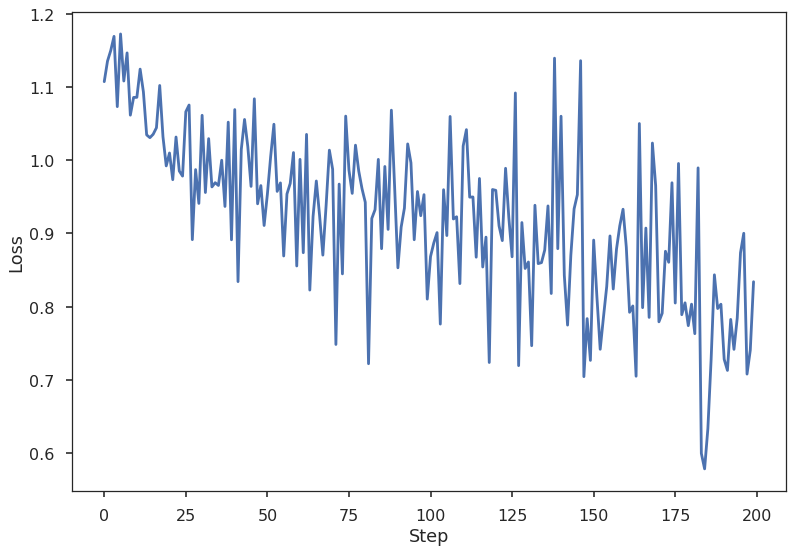

In [92]:
losses = []
for epoch in tqdm(range(100)):
    for seq, seq_char, label in zip(X_train, X_char_train, Y_train):
        loss = get_loss_embedding_lstm_tagger_word_char(model, loss_function, seq, seq_char, label)
        losses.append(loss.data[0])
        ## Get gradients of model params wrt. loss
        loss.backward()
        ## Optimize the loss by one step
        optimizer.step()
        
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")

## CRF model

Adopted from http://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html#sphx-glr-beginner-nlp-advanced-tutorial-py

In [93]:
def to_scalar(var):
    # returns a python float
    return var.view(-1).data.tolist()[0]


def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)


def log_sum_exp_torch(vecs, axis=None):
    ## Use help from: http://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html#sphx-glr-beginner-nlp-advanced-tutorial-py
    if axis < 0:
        axis = vecs.ndimension()+axis
    max_val, _ = vecs.max(axis)
    vecs = vecs - max_val.expand_as(vecs)
    out_val = torch.log(torch.exp(vecs).sum(axis))
    #print(max_val, out_val)
    return max_val + out_val

log_sum_exp_torch(Variable(torch.Tensor([[1,2,3,4]])), axis=-1)

Variable containing:
 4.4402
[torch.FloatTensor of size 1x1]

In [94]:
class CRFLayer(nn.Module):
    def __init__(self, input_size, num_labels):
        super(CRFLayer, self).__init__()
        self.num_labels = num_labels
        self.transitions = nn.Parameter(torch.randn(self.num_labels, self.num_labels))
        
    def _forward_alg(self, emissions):
        scores = emissions[0]
        # Get the log sum exp score
        transitions = self.transitions.transpose(-1,-2)
        for i in range(1, emissions.size(0)):
            scores = emissions[i] + log_sum_exp_torch(
                scores.expand_as(transitions) + transitions,
                axis=1)
        return log_sum_exp_torch(scores, axis=-1)
        
    def _score_sentence(self, emissions, tags):
        score = emissions[0][tags[0]]
        for i, emission in enumerate(emissions[1:]):
            score = score + self.transitions[tags[i], tags[i+1]] + emission[tags[i+1]]
        return score
    
    def _viterbi_decode(self, emissions):
        scores = torch.zeros(emissions.size(1))
        back_pointers = torch.zeros(emissions.size()).int()
        scores = scores + emissions[0]
        transitions = self.transitions
        # Generate most likely scores and paths for each step in sequence
        for i in range(1, emissions.size(0)):
            scores_with_transitions = scores.unsqueeze(1).expand_as(transitions) + transitions
            max_scores, back_pointers[i] = torch.max(scores_with_transitions, 0)
            scores = emissions[i] + max_scores
        # Generate the most likely path
        viterbi = [scores.numpy().argmax()]
        back_pointers = back_pointers.numpy()
        for bp in reversed(back_pointers[1:]):
            viterbi.append(bp[viterbi[-1]])
        viterbi.reverse()
        viterbi_score = scores.numpy().max()
        return viterbi_score, viterbi
        
    def neg_log_likelihood(self, feats, tags):
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
        
    def forward(self, feats):
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(feats)
        return score, tag_seq

In [95]:
class LSTMTaggerWordCharCRF(nn.Module):
    def __init__(self, word_char_embedding, embedding_size, hidden_size, output_size):
        super(LSTMTaggerWordCharCRF, self).__init__()
        self.word_embeddings = word_char_embedding
        self.lstm = nn.LSTM(embedding_size, hidden_size//2, bidirectional=True)
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, X, X_char):
        seq_embed = self.word_embeddings(X, X_char).permute(1, 0, 2)
        out, hidden = self.lstm(seq_embed)
        # Reshape the output to be a tensor of shape seq_len*label_size
        output = self.output(out.view(X.data.size(1), -1))
        return output

In [96]:
model = LSTMTaggerWordCharCRF(word_char_embedding, 8, 4, pos_vocab.size)
features = model.forward(Variable(torch.LongTensor([X_train[0]])), charseq2varlist(X_char_train[0]))
print("Features: ", features)

Features:  Variable containing:
 0.0688 -0.5193 -0.5515
 0.3683 -0.4089 -0.3251
 0.2420 -0.1235 -0.5791
 0.3530 -0.2698 -0.3988
 0.3962 -0.3105 -0.2393
[torch.FloatTensor of size 5x3]



In [97]:
crf = CRFLayer(pos_vocab.size, pos_vocab.size)
optimizer = optim.SGD(model.parameters(), lr=0.1)


def get_loss_embedding_lstm_tagger_word_char_crf(model, crf, seq, seq_char, label, verbose=False):
    ## Clear gradients before every update else memory runs out
    model.zero_grad()
    crf.zero_grad() # Should be CRF
    ## Do forward pass
    feats = model.forward(Variable(torch.LongTensor([seq])),
                              charseq2varlist(seq_char))
    if verbose:
        print(feats)
    ## Get labels
    target  = torch.LongTensor(label)
    if verbose:
        print(target)
    ## Get loss
    loss = crf.neg_log_likelihood(feats, target)
    if verbose:
        print(loss)
    return loss
        

In [98]:
loss = get_loss_embedding_lstm_tagger_word_char_crf(model, crf, X_train[0], X_char_train[0], Y_train[0], verbose=True)

Variable containing:
 0.3928 -0.3722 -0.2801
 0.4573 -0.3955 -0.2676
 0.3235 -0.4032 -0.4429
 0.0522 -0.2860 -0.6642
 0.3608 -0.1675 -0.4417
[torch.FloatTensor of size 5x3]


 0
 1
 2
 0
 1
[torch.LongTensor of size 5]

Variable containing:
 6.1665
[torch.FloatTensor of size 1]



100%|██████████| 100/100 [00:02<00:00, 40.44it/s]


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


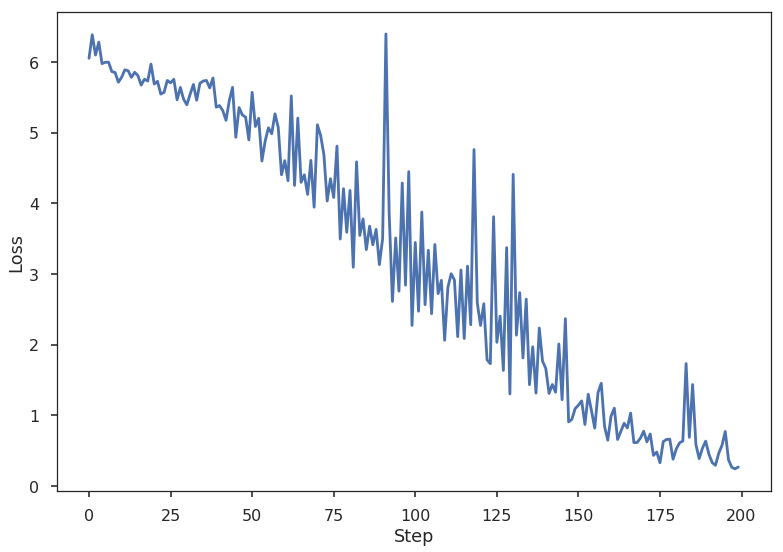

In [99]:
losses = []
for epoch in tqdm(range(100)):
    for seq, seq_char, label in zip(X_train, X_char_train, Y_train):
        loss = get_loss_embedding_lstm_tagger_word_char_crf(model, crf, seq, seq_char, label)
        losses.append(loss.data[0])
        ## Get gradients of model params wrt. loss
        loss.backward()
        ## Optimize the loss by one step
        optimizer.step()
        
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")